# Beat Children at the Board Game Clue

It's the holiday season, and as my family comes together to celebrate the season, we all strive for total domination in the board games we play. These scripts provide a tool which may be updated from an interactive terminal after evey player's turn, and a recommendation for your next play is made.

<br>
<div align='center'><img src='hist.png'></img></div>
<br><br>

## Key components

* Dijkstra's algorithm is used to find efficient paths through the board from any room to any other room.


* A heap implementation of a priority queue is used to explore my current strategy for defeating the children in my family. More on the strategy; each time a guess is made and the next player is asked if their hand contains any cards from the guess, and **and that player passes**, the likelihood that that guess is close to the truth improves. For instance, if I make a guess and 4 people pass before the 5th person provide a card that contradicts the guess, my guess is likely *better* than if I make a guess and the next person is able to provide a card that contradicts my claim. The detailed comments and content in the "adjust_ranking" method attempts to implement this strategy in a quantifiable way


* A simple simulation algorithm compares my method with a simpler, distance based strategy.


* After 100 trials, I make the claim that my algorithm is better than the simpler strategy because the number of total turns required to produce a winner is significantly reduced.
<br><br>

<div align='center'><img src="clue_board.jpg"></img></div>

In [1]:
class Graph:
    # Modified from https://gist.github.com/econchick/4666413
    def __init__(self):
        from collections import defaultdict
        self.nodes = set()
        self.edges = defaultdict(list)
        self.distances = {}

    def add_node(self, value):
        self.nodes.add(value)

    def add_edge(self, from_node, to_node, distance):
        self.edges[from_node].append(to_node)
        self.edges[to_node].append(from_node)
        self.distances[(from_node, to_node)] = distance
        self.distances[(to_node, from_node)] = distance
        
clue_board = Graph()
for room in ['ballroom','billiard','conservatory','dining','kitchen',
             'hall','library','lounge','study']:
    clue_board.add_node(room)
    
# I'm just going to add edges, that given 2 D6 rolls, have
# an expected value 12 or less.
#
# (I wonder if there is more efficient way to add all edges.)
clue_board.add_edge('study','study',2)
clue_board.add_edge('study','kitchen',1)
clue_board.add_edge('study','hall',4)
clue_board.add_edge('study','library',7)
clue_board.add_edge('library','library',2)
clue_board.add_edge('library','billiard',4)
clue_board.add_edge('library','hall',4)
clue_board.add_edge('billiard','billiard',2)
clue_board.add_edge('billiard','conservatory',7)
clue_board.add_edge('conservatory','conservatory',2)
clue_board.add_edge('conservatory','lounge',1)
clue_board.add_edge('conservatory','ballroom',4)
clue_board.add_edge('ballroom','ballroom',2)
clue_board.add_edge('ballroom','dining',7)
clue_board.add_edge('ballroom','kitchen',7)
clue_board.add_edge('ballroom','billiard',6)
clue_board.add_edge('ballroom','library',12)
clue_board.add_edge('kitchen','kitchen',2)
clue_board.add_edge('kitchen','dining',11)
clue_board.add_edge('dining','dining',2)
clue_board.add_edge('dining','lounge',4)
clue_board.add_edge('lounge','lounge',2)
clue_board.add_edge('lounge','hall',8)

def find_path(clue_board, nearest):
    # Modified from https://gist.github.com/econchick/4666413
    best_choices = {nearest: 0}
    paths = {}

    nodes = set(clue_board.nodes)

    while nodes: 
        min_node = None
        for node in nodes:
            if node in best_choices:
                if min_node is None:
                    min_node = node
                elif best_choices[node] < best_choices[min_node]:
                    min_node = node

        if min_node is None:
            break

        nodes.remove(min_node)
        current_weight = best_choices[min_node]

        for edge in clue_board.edges[min_node]:
            weight = current_weight + clue_board.distances[(min_node, edge)]
            if edge not in best_choices or weight < best_choices[edge]:
                best_choices[edge] = weight
                paths[edge] = min_node
    best_choices = [(key,best_choices[key],[]) for key in best_choices]
    best_choices = sorted(best_choices,key=lambda x: x[1])
    return_list =[]
    for idx,(landing,distance,path) in enumerate(best_choices):
        while nearest not in path:
            if nearest==landing:
                path.append(nearest)
            else:
                path.append(paths[landing])
                landing = paths[landing]
        path = path.reverse()
    return(best_choices)

In [2]:
find_path(clue_board,'kitchen')

[('kitchen', 0, ['kitchen']),
 ('study', 1, ['kitchen']),
 ('hall', 5, ['kitchen', 'study']),
 ('ballroom', 7, ['kitchen']),
 ('library', 8, ['kitchen', 'study']),
 ('conservatory', 11, ['kitchen', 'ballroom']),
 ('dining', 11, ['kitchen']),
 ('lounge', 12, ['kitchen', 'ballroom', 'conservatory']),
 ('billiard', 12, ['kitchen', 'study', 'library'])]

In [3]:
class Clue:
    def __init__(self,my_cards,token, clue_board,verbose):
        self.clue_board = clue_board
        import random
        self.random = random
        from matplotlib import pyplot as plt
        self.plt = plt
        import matplotlib.gridspec as gridspec
        from heapq import heappush, heappop
        self.push = heappush
        self.pop  = heappop
        self.verbose = verbose
        self.suspects = ['green','peacock','white','plum','mustard','scarlet']
        self.weapons  = ['candlestick','knife','pipe','revolver','rope','wrench']
        self.rooms    = ['ballroom','billiard','conservatory','dining','kitchen',
                         'hall','library','lounge','study']
        possibilities = \
            [(0,'{} in the {} with the {}'.format(i,j,k)) \
             for i in self.suspects for j in self.rooms for k in self.weapons]
        self.possibilities = []
        for priority,claim in possibilities:
            for card in my_cards:
                if not card in claim:
                    self.possibilities.append((priority,claim))
        self.fontsize = 15 
        self.my_cards = my_cards
        self.token = token
        if token == 'green':
            self.nearest_room = 'ballroom'
        if token == 'peacock':
            self.nearest_room = 'conservatory'
        if token == 'white':
            self.nearest_room = 'ballroom'
        if token == 'plum':
            self.nearest_room = 'study'
        if token == 'mustard':
            self.nearest_room = 'dining'
        if token == 'scarlet':
            self.nearest_room = 'lounge'
        
    def eliminate_card(self,card):
        self.possibilities = [(priority,claim) for priority,claim in self.possibilities if card not in claim]
        
    def adjust_rank(self,suspect,weapon,room,passes):   
        claim_str = '{} in the {} with the {}'.format(suspect,room,weapon)
        try:
            if claim_str in self.guess_history:
                raise Exception('You already guessed {}'.format(claim_str))
        except AttributeError:
            self.guess_history = []
        # Add one to passes, because guessr passes by default.
        passes = passes + 1
        # Each pass represents 3 cards not in the guilty 3-tuple
        # More passes => better guess
        # 6 players, 3 cards each and 0 passes gives max penalty
        penalty_weight = 6*3-passes*3
        self.guess_history.append(claim_str)
        self.possibilities = [(priority,claim) for priority,claim in self.possibilities if claim != claim_str]
        # Assume Earlier matches with opponent hands are worse guesses
        # Hypothesis: The product of penalty weight and number of guess elements
        #             contained in a possible 3tuple will penalize unlikely guesses
        #             and extracting form minheap will produce winner more quickly
        #             random guessing.
        adjustments = dict([(claim,penalty_weight*sum(map(claim.count,(suspect,room,weapon)))) for priority,claim in self.possibilities])
        self.possibilities = [(priority+adjustments[claim],claim) for priority,claim in self.possibilities]
        # Note: possibilities is list and adjustments is dict. Optimization takes 
        #       advantage of dict hash table and index inversion

    def best_guess(self,nearest_room):
        h = []
        for element in self.possibilities:
            self.push(h,element)
        this_top = self.pop(h)
        tmp = list(h)
        cnt = 0
        try: 
            while this_top[0] == self.pop(tmp)[0]:
                cnt += 1
        except IndexError:
            # Will get index error if all elements
            # have identical priority. Not necessarily
            # a problem if IndexError occurs.
            pass
            
        equal_likelihood = [this_top] + [self.pop(h) for _ in range(cnt)]

        all_paths = self.find_path(nearest_room)
        names = [item[1].split(' ')[3] for item in equal_likelihood]
        guess_key = {}
        for each in equal_likelihood:
            guess_key[each[1].split(' ')[3]] = each[1]
        for idx,_ in enumerate(all_paths):
            if all_paths[idx][0] in names:
                self.nearest_room = all_paths[idx][0]
                if self.verbose:
                    print('Best path is from '+' to '.join(all_paths[idx][2])+' to {}.'.format(all_paths[idx][0]))
                return(guess_key[all_paths[idx][0]])

    def bad_guess(self,nearest_room):
        all_paths = self.find_path(nearest_room)
        some_paths = [i for i in all_paths if i[1] < 6]
        next_room = self.random.choice(some_paths)
        some_possibilities = [i for i in self.possibilities if next_room[0]==i[1].split(' ')[3]]
        if len(some_possibilities)==0:
            bad_pick = self.random.choice(self.possibilities)
        else:
            bad_pick = self.random.choice(some_possibilities)
            idx = 0
            while len(all_paths[idx][2]) > 1:
                bad_pick = self.random.choice(self.possibilities)
                idx += 1
        self.nearest_room = bad_pick[1].split(' ')[3]
        return(bad_pick[1])

    def check_guess(self,answer,claim):
        return(answer==claim)
    
    def check_claim(self,cards):
        shuffled_cards = self.my_cards
        for card in cards:
            if card in shuffled_cards:
                return(card)
        return(None)
    
    def make_hist(self,ax):
        fontsize = self.fontsize
        these_data = [float(pri) for pri,_ in self.possibilities]
        max_pri = max([pri for pri in these_data])
        these_data = [(max_pri-this_pri)/max_pri for this_pri in these_data]
        these_data = [i if i != 0 else 0.1 for i in these_data]

        ax.hist(these_data,range=(0.1,1))
        ax.set_ylabel('Count',fontsize=fontsize)
        ax.set_xlabel('Less likely'+' '*70+'More likely',fontsize=fontsize)
        ax.xaxis.set_ticklabels([])
        ax.set_title('Likelihood Histogram',fontsize=fontsize+5)

    def make_top(self,ax):
        fontsize = self.fontsize
        h = []
        for each in self.possibilities:
            self.push(h,each)
        
        this_top = self.pop(h)
        tmp = list(h)
        cnt = 0
        while this_top[0] == self.pop(tmp)[0]:
            cnt += 1
        top_n = [self.pop(h) for _ in range(cnt+1)]
        max_n = max([pri for pri,_ in top_n])
        top_n = [((max_n-this_n[0])/max_n,this_n[1]) for this_n in top_n]
        top_n = [ (i,j) if i != 0 else (0.1,j) for i,j in top_n]
        top_n = sorted(top_n,key=lambda x: x[0])
      
        if len(top_n) < 13:
            ax.barh(range(len(top_n)),
                    [float(priority) for priority,claim in top_n],align='center')
            ax.yaxis.set_ticklabels([claim for _,claim in top_n],
                                    fontsize=fontsize)
            ax.set_yticks(range(len(top_n)))
            ax.set_xlabel('Less likely'+' '*70+'More likely',
                          fontsize=fontsize)
            ax.set_xlim(left=0)
            ax.set_title('Here are the best picks...',
                         fontsize=fontsize+5)
            ax.xaxis.set_ticklabels([])
        else:
            ax.text(0.5,0.5,
                    'Keep playing.\nI\'ll show you more when \nyou\'ve narrowed it down',
                    fontsize=fontsize+20,
                    ha='center',va='center')
            ax.set_xticks([])
            ax.set_yticks([])
        
    def show_panel(self):
        fig, (ax1, ax2) = self.plt.subplots(nrows=2, ncols=1,figsize=(10,10))
        _ =self.make_hist(ax1)
        _ =self.make_top(ax2)
        _ =self.plt.show()
        
    # Find all the shortest paths from the nearest room
    # using Dijkstras algorithm
    def find_path(self, nearest):
        # Modified from https://gist.github.com/econchick/4666413
        best_choices = {nearest: 0}
        paths = {}

        nodes = set(self.clue_board.nodes)

        while nodes: 
            min_node = None
            for node in nodes:
                if node in best_choices:
                    if min_node is None:
                        min_node = node
                    elif best_choices[node] < best_choices[min_node]:
                        min_node = node

            if min_node is None:
                break

            nodes.remove(min_node)
            current_weight = best_choices[min_node]

            for edge in self.clue_board.edges[min_node]:
                weight = current_weight + self.clue_board.distances[(min_node, edge)]
                if edge not in best_choices or weight < best_choices[edge]:
                    best_choices[edge] = weight
                    paths[edge] = min_node
                    
        best_choices = [(key,best_choices[key],[]) for key in best_choices]
        best_choices = sorted(best_choices,key=lambda x: x[1])
        
        return_list =[]
        for idx,(landing,distance,path) in enumerate(best_choices):
            while nearest not in path:
                if nearest==landing:
                    path.append(nearest)
                else:
                    path.append(paths[landing])
                    landing = paths[landing]
            path = path.reverse()
        return(best_choices)
    
    def dump(self):
        return(self.possibilities)


In [4]:
def make_answer():
    import random
    suspects = ['green','peacock','white','plum','mustard','scarlet']
    weapons  = ['candlestick','knife','pipe','revolver','rope','wrench']
    rooms    = ['ballroom','billiard','conservatory','dining','kitchen',
                             'hall','library','lounge','study']
    return('{} in the {} with the {}'.format(random.choice(suspects),random.choice(rooms),random.choice(weapons)))

In [5]:
def make_hands(players,truth,verbose):
    import random
    import numpy as np
    suspects = ['green','peacock','white','plum','mustard','scarlet']
    weapons  = ['candlestick','knife','pipe','revolver','rope','wrench']
    rooms    = ['ballroom','billiard','conservatory','dining','kitchen',
                             'hall','library','lounge','study']
    cards = suspects + weapons + rooms
    truth = [truth.split(' ')[i] for i in [0,3,6]]
    cards = [card for card in cards if card not in truth]
    hands = []
    for i in range(len(players)*3):
        choice = random.choice(cards)
        cards.remove(choice)
        hands.append(choice)
    hands = [[str(this_str) for this_str in this_list] for this_list in np.reshape(hands,(len(players),3))]
    collection = {}
    for idx,player in enumerate(players):
        collection[player] = Clue(hands[idx],suspects[idx],clue_board,verbose)
    return(collection)

In [6]:
player1 = Clue(my_cards=['rope','revolver','library'],
               token='white',
               clue_board=clue_board,
               verbose=False)

In [7]:
player1.check_claim(['rope','revolver','dallas'])

'rope'

In [8]:
player1.eliminate_card('white')
player1.eliminate_card('plum')
player1.eliminate_card('green')
player1.eliminate_card('mustard')
player1.eliminate_card('revolver')
player1.eliminate_card('rope')
player1.eliminate_card('kitchen')
player1.eliminate_card('ballroom')
player1.eliminate_card('dining')
player1.eliminate_card('hall')
player1.eliminate_card('library')
player1.eliminate_card('knife')
player1.eliminate_card('billiard')
player1.eliminate_card('candlestick')

In [9]:
player1.adjust_rank(suspect='green',room='conservatory',weapon='pipe',passes=2)

In [10]:
player1.best_guess('kitchen')

'scarlet in the study with the wrench'

In [11]:
player1.bad_guess('kitchen')

'peacock in the study with the pipe'

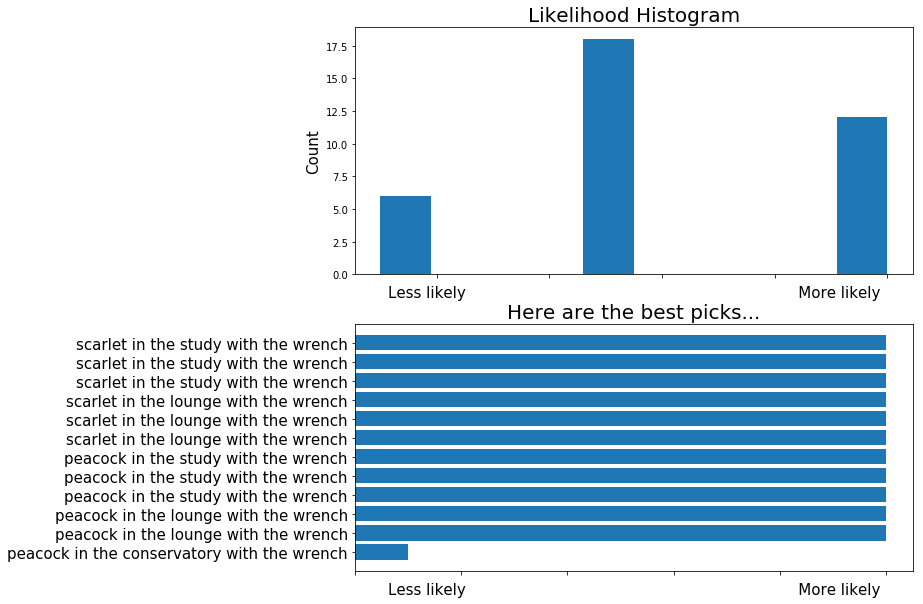

In [12]:
player1.show_panel()

In [13]:
def do_game(game, bad, truth, verbose = False, safety_lim = 100):
    this_answer = 'Nobody in the nowhere because I am traveling'
    safety = 0
    order = game.keys()
    idx = 0
    inner_idx = 0
    while this_answer != truth and safety < safety_lim:
        safety += 1
        if verbose:
            print('-'*20+order[idx].upper()+'-'*20)
            print(order[idx] + " is nearest to " + game[order[idx]].nearest_room + " and their token is " +game[order[idx]].token)
        if bad:
            this_answer = game[order[idx]].bad_guess(game[order[idx]].nearest_room)
        else:
            this_answer = game[order[idx]].best_guess(game[order[idx]].nearest_room)
        if verbose:
            print(order[idx]+" thinks best guess is currently: "+this_answer)
        if this_answer != truth:
            if inner_idx == len(order)-1:
                inner_idx = 0
            else:
                inner_idx += 1
            pass_cnt = 0
            hint = None
            while hint == None:
                if verbose:
                    print("outer, inner: {}, {}".format(idx,inner_idx))
                    print(order[idx]+" asking "+order[inner_idx]+" if they have "+str([this_answer.split(' ')[i] for i in [0,3,6]]))
                hint = game[order[inner_idx]].check_claim([this_answer.split(' ')[i] for i in [0,3,6]])
                if verbose:
                    print(order[inner_idx]+" has "+str(game[order[inner_idx]].my_cards))
                    print("Current hint is "+str(hint))
                if inner_idx == len(order)-1:
                    inner_idx = 0
                else:
                    inner_idx += 1
                pass_cnt += 1
            game[order[idx]].adjust_rank(*[this_answer.split(' ')[i] for i in [0,6,3]],passes=pass_cnt)
            game[order[idx]].eliminate_card(hint)
            if verbose:
                print(order[idx]+" guesses "+this_answer)
                #if order[idx] =='mbali':
                #    game[order[idx]].show_panel()
                print('Visted outer loop {} times'.format(safety))
            if safety == safety_lim:
                print("Relax safety parameter")
        else:
            if verbose:
                print("We have a winner! {} guessed {} in {} turns".format(order[idx],this_answer,safety))
            else:
                return(safety)

        if idx == len(order)-1:
            idx = 0
        else:
            idx += 1


In [14]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [15]:
bad_guesses    = []
better_guesses = []
for _ in range(100):
    truth = make_answer()
    game = make_hands(['cookie','dick','alicia','quincy','mbali','tigger'],truth,verbose=False)
    bad_guesses.append(do_game(game,bad=True,verbose=False,truth=truth))
    better_guesses.append(do_game(game,bad=False,verbose=False,truth=truth))
    #bad_guesses.append(do_game(game,bad=True,verbose=True))
    #better_guesses.append(do_game(game,bad=False))

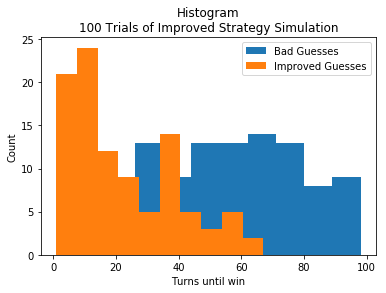

In [16]:
_ = plt.hist(bad_guesses,label='Bad Guesses')
_ = plt.title('Histogram\n100 Trials of Basic Strategy Simulation')
_ = plt.ylabel('Count')
_ = plt.xlabel('Turns until win')
_ = plt.hist(better_guesses,label='Improved Guesses')
_ = plt.title('Histogram\n100 Trials of Improved Strategy Simulation')
_ = plt.ylabel('Count')
_ = plt.legend()
_ = plt.xlabel('Turns until win')